In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Broadcast
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
spark = SparkSession \
        .builder \
        .master('local') \
        .appName('restaurants') \
        .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.2') \
        .config('spark.mongodb.input.uri', 'mongodb://mongo/test.rests') \
        .config('spark.mongodb.output.uri', 'mongodb://mongo/test.rests') \
        .getOrCreate()

In [52]:
DF = spark.read.format('mongo').load()

In [4]:
DF.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- address: string (nullable = true)
 |-- check_group: string (nullable = true)
 |-- comments: struct (nullable = true)
 |    |-- comments__count: integer (nullable = true)
 |    |-- comments: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- comment__rating: double (nullable = true)
 |    |    |    |-- comment__body: string (nullable = true)
 |-- coords: struct (nullable = true)
 |    |-- coords__lat: double (nullable = true)
 |    |-- coords__lon: double (nullable = true)
 |-- district: string (nullable = true)
 |-- kitchen_types: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- name: string (nullable = true)
 |-- rating: struct (nullable = true)
 |    |-- rating__mean: double (nullable = true)
 |    |-- rating__food: double (nullable = true)
 |    |-- rating__service: double (nullable = true)
 |    |-- rating__price_quality: dou

In [6]:
ё = [
    'адмиратлейский',
    'василеостровский',
    'выборгский',
    'калининский',
    'кировский',
    'колпинский',
    'красногвардейский',
    'красносельский',
    'кронштадский',
    'курортный',
    'московский',
    'невский',
    'петроградский',
    'петродворцовый',
    'приморский',
    'пушкинский',
    'фрунзенский',
    'центральный'
]

In [53]:
# drop rows if main features is null or not in allowed list

df = DF.filter(DF['address'].isNotNull()) \
        .filter(DF['district'].isNotNull()) \
        .filter(DF['district'].isin(SPbDistricts)) \
        .filter(DF['coords'].isNotNull()) \
        .filter(DF['rating.rating__mean'].isNotNull())

In [165]:
# show some statistics

stats = df[['rating.*', 'comments.comments__count']].describe() \
            .select('summary',
                *(F.round(F.col(c), 5).alias(c)
                  for c in df[['rating.*', 'comments.comments__count']].columns))

stats.toPandas()

,summary,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,count,2791.00000,963.00000,968.00000,965.00000,274.00000,2765.00000
1,mean,4.01021,4.15369,4.16374,4.07202,4.21898,34.48969
2,stddev,0.76948,0.49818,0.49537,0.49083,0.50223,111.68417
3,min,1.00000,2.00000,2.00000,1.50000,1.50000,1.00000
4,max,5.00000,5.00000,5.00000,5.00000,5.00000,1543.00000


In [166]:
# show average rate by districts

districts_rate = df[['district', 'rating.*']].groupBy('district').mean().sort(F.col('avg(rating__mean)').desc()) \
                    .select('district',
                        *(F.round(F.col('avg('+c+')'), 5).alias(c)
                            for c in df[['rating.*']].columns))

districts_rate.toPandas()

,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere
0,курортный,4.16316,4.02632,4.01250,3.91250,4.22222
1,центральный,4.14667,4.25260,4.27431,4.19338,4.27528
2,петроградский,4.08032,4.13725,4.18932,4.00000,4.27941
3,петродворцовый,4.05921,4.27083,4.14583,4.04167,4.33333
4,колпинский,4.05172,4.25000,4.30000,4.05000,4.16667
5,пушкинский,4.04545,4.13235,4.10000,3.97143,4.20000
6,василеостровский,4.04198,4.13725,4.10577,4.15385,4.26667
7,приморский,3.95631,4.28070,4.23276,4.12069,4.25000
8,невский,3.95079,3.95652,4.00000,3.92609,4.01316
9,выборгский,3.93290,3.96825,4.05556,3.89344,4.17647


In [81]:
# show districts with count of restaurants kitchen types

# step 1 - collect kitchen types set (unique)
kitchen_types_dist = list(map(lambda x: x.col, list(set(df.select(F.explode('kitchen_types')).collect()))))

In [164]:
# step 2 - group kitchen types to set by district and then flatten nested arrays
kitchen_types_by_district = df[['district', 'kitchen_types']] \
    .groupBy('district').agg(F.collect_set('kitchen_types').alias('kitchen_types')) \
    .select('district', F.flatten('kitchen_types').alias('kitchen_types'))

kitchen_types_by_district.show()

+-----------------+--------------------+
|         district|       kitchen_types|
+-----------------+--------------------+
|    петроградский|[Японская, Европе...|
|      фрунзенский|[Итальянская, Япо...|
|       выборгский|[Европейская, Рус...|
|   петродворцовый|[Европейская, Рус...|
| василеостровский|[Японская, Суши, ...|
|красногвардейский|[Кафе, Европейска...|
|          невский|[Китайская, Италь...|
|       московский|[Итальянская, Мор...|
|        кировский|[Европейская, Рус...|
|      калининский|[Европейская, Ази...|
|       пушкинский|[Европейская, Ази...|
|       приморский|[Закусочная, Улич...|
|   красносельский|[Китайская, Азиат...|
|      центральный|[Американская, Ев...|
|        курортный|[Европейская, Ази...|
|       колпинский|[Восточноевропейс...|
+-----------------+--------------------+



In [135]:
# function to calculate number of occurrences of a value in array in cell
@F.udf('int')
def number_of_in_array(col, target):
    n = 0
    for v in col:
        if v == target:
            n += 1
    return n

# step 3 - create collumns from set of kitchen types and
#     fill it with number of restaurants of this type
kitchen_types_by_district_counts = kitchen_types_by_district[['district', 'kitchen_types']] \
    .groupBy('district').agg(F.collect_set('kitchen_types').alias('kitchen_types')) \
    .select('district', F.flatten('kitchen_types').alias('kitchen_types')) \
    .select('district', (*(number_of_in_array('kitchen_types', F.lit(c)).alias(c) for c in kitchen_types_dist)))

kitchen_types_by_district_counts.toPandas()

,district,Кафе,Шотландская,Скандинавская,Камбоджийская,Паб с пивоварней,Чилийская,Морепродукты,Ближневосточная,Гастропаб,Тибетская,Барбекю,Индонезийская,Малазийская,Центральноевропейская,Закусочная,Испанская,Индийская,Кубинская,Японская кухня-фьюжн,Французская,Немецкая,Азиатская,Венесуэльская,Итальянская,Северно-итальянская,Китайская,Новозеландская,Австрийская,Сицилийская,Пицца,Вьетнамская,Тосканская,Ирландская,Греческая,Румынская,Европейская,Фьюжн,Узбекская,Японская,Бельгийская,Тайваньская,Швейцарская,Гавайская,Арабская,Центральноамериканская,Корейская,Шведская,Восточноевропейская,Чешская,Венгерская,Супы,Бар,Хорватская,Кухня Кампании,Стейк-хаус,Здоровая,Перуанская,Фастфуд,Грузинская,Тайская,Суши,Пакистанская,Украинская,Кавказская,Костариканская,Южно-итальянская,Уличная еда,Латиноамериканская,Израильская,Американская,Кухня Эмилии-Романьи,Современная,Неаполитанская,Польская,Средиземноморская,Азербайджанская,Центральноазиатская,Винный бар,Русская,Марокканская,Датская,Юговосточная,Паб,Британская,Гриль,Австралийская,Аргентинская,Мексиканская,Гастроном,Пивные рестораны,Турецкая,Южноамериканская,Центрально-итальянская,Бары с рестораном,Армянская,Ливанская,Карибская,Международная,Португальская,Словенская,Индейская,Голландская,Римская
0,петроградский,14,0,2,0,1,0,15,10,2,0,4,1,0,16,2,4,4,0,0,8,2,14,0,26,0,4,0,0,0,7,1,0,0,1,0,69,3,2,18,3,0,0,1,1,2,1,0,12,0,0,3,20,0,0,3,3,1,8,11,1,11,0,0,5,0,0,2,1,2,8,0,6,0,0,8,2,0,5,46,0,0,0,13,1,5,0,1,6,1,0,0,4,0,0,2,1,0,3,0,0,1,1,0
1,фрунзенский,3,0,1,1,0,0,1,3,0,0,0,0,1,2,1,1,0,0,0,0,0,3,0,8,0,2,0,1,0,5,3,0,1,0,0,20,1,1,11,0,1,0,0,0,0,1,0,4,0,0,0,5,0,0,0,2,0,7,2,2,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0,13,0,0,0,6,1,2,0,0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0
2,выборгский,5,0,0,0,3,0,4,9,1,0,3,0,0,5,0,1,1,1,0,1,1,3,0,11,0,3,0,0,0,9,0,0,2,1,1,41,0,3,9,1,0,1,0,0,0,1,0,17,2,0,3,13,0,0,2,0,0,8,8,0,5,1,1,6,1,0,2,1,0,11,0,2,0,0,4,1,0,1,29,0,0,0,14,0,6,0,0,2,0,0,3,2,0,0,2,0,1,5,0,1,0,0,0
3,петродворцовый,2,0,0,0,0,0,1,1,1,0,2,0,0,1,0,0,0,0,0,0,0,2,0,7,0,1,0,0,0,1,0,0,0,1,0,21,0,0,5,0,0,0,0,0,0,0,0,8,1,0,0,4,0,0,3,0,0,2,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,4,0,0,1,16,0,0,0,3,0,1,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
4,василеостровский,1,0,1,0,0,0,4,5,0,0,2,1,0,7,0,0,2,0,0,2,1,4,1,14,0,4,0,0,0,9,2,0,0,0,0,36,1,3,9,1,0,0,0,0,0,1,0,9,1,0,2,10,0,0,2,0,0,5,5,3,3,0,1,5,0,0,0,0,1,6,0,3,0,0,4,1,0,5,28,1,0,0,7,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0
5,красногвардейский,5,0,0,0,1,0,2,2,2,0,0,0,0,4,0,0,0,0,0,1,3,4,0,8,0,4,0,0,0,6,0,0,0,1,0,22,0,1,8,0,0,0,0,1,0,0,0,4,1,0,0,5,0,1,0,0,0,4,1,1,7,0,0,1,0,1,0,0,0,2,0,1,1,0,1,0,0,1,20,0,0,0,7,0,1,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0
6,невский,12,0,0,0,0,1,4,6,0,0,0,0,0,9,2,1,1,0,0,3,2,12,0,17,0,6,0,0,0,11,4,0,2,2,0,52,0,3,19,3,0,0,0,0,0,1,0,13,1,0,2,15,0,0,1,1,0,11,4,4,12,1,0,2,0,0,1,0,0,9,0,0,0,0,3,0,0,2,35,0,0,0,13,0,2,0,0,3,0,0,1,1,0,0,0,0,0,7,0,0,0,0,0
7,московский,7,1,0,0,1,0,5,4,0,0,4,0,0,10,6,2,0,0,0,2,3,12,0,22,0,3,0,0,0,10,0,0,1,0,0,45,2,0,19,2,0,0,0,0,0,2,0,5,0,0,4,13,0,0,2,1,0,8,9,0,10,0,0,4,0,0,0,0,0,8,0,3,0,0,3,1,0,1,24,0,0,0,16,1,4,1,1,3,0,0,0,2,0,1,1,0,1,2,1,0,0,0,0
8,кировский,3,0,0,0,0,0,0,5,1,0,0,0,0,1,1,0,0,0,0,0,1,2,0,9,0,1,0,0,0,6,0,0,2,0,0,30,0,1,9,0,0,0,0,0,0,1,0,8,0,0,2,4,0,0,3,0,0,4,2,1,4,0,0,1,0,0,0,0,0,3,0,0,0,0,2,0,0,0,18,0,0,0,9,0,2,2,0,1,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0
9,калининский,5,0,0,0,0,0,2,4,0,0,2,0,0,5,1,0,1,0,0,2,1,2,0,2,0,2,0,0,0,3,0,0,1,0,0,21,0,0,8,0,0,0,0,0,0,0,0,4,0,0,2,6,0,0,0,1,0,5,3,1,4,1,0,2,0,0,0,1,0,6,0,1,0,0,2,1,0,0,14,0,0,0,6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


In [161]:
# (optional) step 4 - create dict of columns names and sum of values in this columns
kitchen_types_sum = {
    c: s for c, s in \
        zip(
            kitchen_types_by_district_counts.columns[1:],
            (kitchen_types_by_district_counts[[c_]].groupBy().sum().take(1)[0][0] \
                for c_ in kitchen_types_by_district_counts.columns[1:])
        )
}

# sort dict by values
kitchen_types_sum = {k: v for k, v in sorted(kitchen_types_sum.items(), key=lambda x: x[1], reverse=True)}

# reorder columns by sum of values
kitchen_types_by_district_counts_reordered = kitchen_types_by_district_counts \
    .select('district', (*(F.col(c).alias(c) for c in kitchen_types_sum)))

kitchen_types_by_district_counts_reordered.toPandas()

,district,Европейская,Русская,Итальянская,Бар,Японская,Паб,Восточноевропейская,Азиатская,Фастфуд,Кафе,Центральноевропейская,Американская,Пицца,Суши,Морепродукты,Грузинская,Ближневосточная,Международная,Средиземноморская,Китайская,Гриль,Кавказская,Современная,Супы,Винный бар,Французская,Стейк-хаус,Тайская,Мексиканская,Закусочная,Гастропаб,Барбекю,Здоровая,Уличная еда,Немецкая,Узбекская,Вьетнамская,Фьюжн,Бельгийская,Корейская,Испанская,Индийская,Южноамериканская,Азербайджанская,Ирландская,Турецкая,Чешская,Паб с пивоварней,Греческая,Армянская,Скандинавская,Латиноамериканская,Израильская,Арабская,Украинская,Индонезийская,Британская,Чилийская,Малазийская,Перуанская,Южно-итальянская,Португальская,Австрийская,Гавайская,Центральноамериканская,Пакистанская,Неаполитанская,Центральноазиатская,Марокканская,Австралийская,Аргентинская,Центрально-итальянская,Ливанская,Новозеландская,Сицилийская,Венгерская,Кухня Кампании,Юговосточная,Гастроном,Бары с рестораном,Карибская,Голландская,Шотландская,Камбоджийская,Тибетская,Кубинская,Японская кухня-фьюжн,Венесуэльская,Северно-итальянская,Тосканская,Румынская,Тайваньская,Швейцарская,Шведская,Хорватская,Костариканская,Кухня Эмилии-Романьи,Польская,Датская,Пивные рестораны,Словенская,Индейская,Римская
0,петроградский,69,46,26,20,18,13,12,14,8,14,16,8,7,11,15,11,10,3,8,4,5,5,6,3,5,8,3,1,6,2,2,4,3,2,2,2,1,3,3,1,4,4,4,2,0,0,0,1,1,2,2,1,2,1,0,1,1,0,0,1,0,0,0,1,2,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,фрунзенский,20,13,8,5,11,6,4,3,7,3,2,1,5,3,1,2,3,2,0,2,2,0,1,0,0,0,0,2,1,1,0,0,2,0,0,1,3,1,0,1,1,0,0,2,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,выборгский,41,29,11,13,9,14,17,3,8,5,5,11,9,5,4,8,9,5,4,3,6,6,2,3,1,1,2,0,2,0,1,3,0,2,1,3,0,0,1,1,1,1,2,1,2,3,2,3,1,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
3,петродворцовый,21,16,7,4,5,3,8,2,2,2,1,4,1,0,1,2,1,2,4,1,1,0,0,0,1,0,3,0,2,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,василеостровский,36,28,14,10,9,7,9,4,5,1,7,6,9,3,4,5,5,1,4,4,1,5,3,2,5,2,2,3,1,0,0,2,0,0,1,3,2,1,1,1,0,2,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,красногвардейский,22,20,8,5,8,7,4,4,4,5,4,2,6,7,2,1,2,2,1,4,1,1,1,0,1,1,0,1,2,0,2,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,невский,52,35,17,15,19,13,13,12,11,12,9,9,11,12,4,4,6,7,3,6,2,2,0,2,2,3,1,4,3,2,0,0,1,1,2,3,4,0,3,1,1,1,1,0,2,1,1,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,московский,45,24,22,13,19,16,5,12,8,7,10,8,10,10,5,9,4,2,3,3,4,4,3,4,1,2,2,0,3,6,0,4,1,0,3,0,0,2,2,2,2,0,2,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,кировский,30,18,9,4,9,9,8,2,4,3,1,3,6,4,0,2,5,6,2,1,2,1,0,2,0,0,3,1,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,калининский,21,14,2,6,8,6,4,2,5,5,5,6,3,4,2,3,4,2,2,2,1,2,1,2,0,2,0,1,1,1,0,2,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [194]:
# create top of restaurants by average rating and number of reviews
#     and show top 10

top10byavg = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__mean').desc(),
          F.col('comments.comments__count').desc())

top10byavg.limit(10).toPandas()

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Пхали-Хинкали,"проспект Юрия Гагарина, 71, Санкт-Петербург 196143 Россия",московский,5.0,4.5,4.5,4.5,None,764
1,Пхали-Хинкали,"пр-кт Ветеранов, 160, Санкт-Петербург 198264 Россия",кировский,5.0,4.5,4.5,4.5,None,341
2,Meal,"Литейный пр., 17-19, Санкт-Петербург 191028 Россия",центральный,5.0,5.0,5.0,5.0,None,137
3,Спирит Гастробар,"Большая Морская, 36, Санкт-Петербург 190000 Россия",центральный,5.0,NaN,NaN,NaN,None,97
4,Uno Due Tre Cafe,"ул. Тверская, 20, Санкт-Петербург 191124 Россия",колпинский,5.0,5.0,5.0,5.0,None,82
5,Гринбокс,"Невский проспект, 63, Санкт-Петербург 191025 Россия",невский,5.0,4.5,5.0,4.0,None,81
6,Tootsie,"9-я линия В.О., 30, Санкт-Петербург 199004 Россия",василеостровский,5.0,5.0,5.0,5.0,None,69
7,Don Garcia Taqueria,"Ильюшина, 14 ТЦ Долгоозёрный, Санкт-Петербург 197372 Россия",приморский,5.0,5.0,5.0,5.0,None,64
8,My Friends Pub,"ул. Кирочная, 11, Санкт-Петербург 191014 Россия",центральный,5.0,4.5,4.5,4.5,None,62
9,EZO Izakaya,"Волынский пер., 8, Санкт-Петербург 191186 Россия",центральный,5.0,4.5,5.0,4.5,None,61


In [190]:
# create top of restaurants by food rating and number of reviews
#     and show top 10

top10byfood = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__food').desc(),
          F.col('comments.comments__count').desc())

top10byfood.limit(10).toPandas()

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Ресторан Вино & Вода,"ул. Чайковского, 17 Oтель Индиго, Санкт-Петербург 191187 Россия",центральный,4.5,5.0,4.5,4.5,4.5,394
1,Пхали-Хинкали,"Комендантский пр., д. 27 к. 1, Санкт-Петербург 197371 Россия",приморский,4.5,5.0,4.5,4.5,NaN,392
2,Брассерия Крик,"Невский пр., 64, Санкт-Петербург 191023 Россия",невский,4.5,5.0,4.5,4.5,NaN,143
3,"Ресторан ""Центральный""","Суворовский проспект, 62, Санкт-Петербург 191124 Россия",петродворцовый,4.5,5.0,5.0,4.5,NaN,139
4,Meal,"Литейный пр., 17-19, Санкт-Петербург 191028 Россия",центральный,5.0,5.0,5.0,5.0,NaN,137
5,Форно Браво,"пл. Льва Толстого 1/3, Санкт-Петербург 197022 Россия",петроградский,4.5,5.0,4.5,4.5,NaN,136
6,Gills,"ул. Казанская, 8-10, Санкт-Петербург 191186 Россия",центральный,4.5,5.0,4.5,4.5,NaN,103
7,Meat Bar,"ул. Жуковского, 22, Санкт-Петербург 191014 Россия",центральный,4.5,5.0,4.5,5.0,NaN,84
8,Uno Due Tre Cafe,"ул. Тверская, 20, Санкт-Петербург 191124 Россия",колпинский,5.0,5.0,5.0,5.0,NaN,82
9,"""Ягер"" рестопаб","Средний проспект В.О., д. 64 м. Василеостровская, Санкт-Петербург 199178 Россия",пушкинский,4.5,5.0,4.5,4.5,4.5,79


In [191]:
# create top of restaurants by atmosphere rating and number of reviews
#     and show top 10

top10byatmosphere = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__atmosphere').desc(),
          F.col('comments.comments__count').desc())

top10byatmosphere.limit(10).toPandas()

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Пхали-Хинкали,"Просвещения пр-т, 53 корп. 1, Санкт-Петербург 195274 Россия",выборгский,4.5,4.5,4.5,4.5,5.0,836
1,Укроп на М.Конюшенной,"ул. Малая Конюшенная, 14, Санкт-Петербург 191186 Россия",центральный,4.5,4.5,4.5,4.5,5.0,833
2,Укроп на 7-ой Линии,"7-я Линия В.О., 30, Санкт-Петербург 199004 Россия",василеостровский,4.5,4.5,5.0,4.5,5.0,404
3,Макарена,"Московский проспект, 206, Санкт-Петербург Россия",московский,4.5,4.5,4.5,4.5,5.0,280
4,Ресторан-фондю Чердак Художника,"ул. Ломоносова, 1/28, Санкт-Петербург 191011 Россия",центральный,4.5,4.5,4.5,4.0,5.0,195
5,Чердак,"ул. Куйбышева, д. 38/40, Санкт-Петербург 197046 Россия",петроградский,4.5,4.5,4.5,4.5,5.0,179
6,Чердак,"Лиговский проспект, д. 17, Санкт-Петербург 191014 Россия",центральный,4.5,4.5,4.5,4.5,5.0,79
7,Булочная Гарсон,"Невский проспект, д.103, Санкт-Петербург Россия",невский,4.0,4.0,4.5,4.0,5.0,65
8,Daddy’s Irish Pub,"Луначарского проспект, д. 52, корп. 1 м. Озерки, Санкт-Петербург 194356 Россия",калининский,4.5,4.5,4.5,4.5,5.0,50
9,Маркетплейс,"Конституции площадь, д. 3А, Санкт-Петербург 196247 Россия",московский,4.0,4.0,4.0,4.0,5.0,43


In [192]:
# create top of restaurants by service rating and number of reviews
#     and show top 10

top10byatmosphere = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__service').desc(),
          F.col('comments.comments__count').desc())

top10byatmosphere.limit(10).toPandas()

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Restaurant Schengen,"Кирочная ул., 5, Санкт-Петербург 191028 Россия",центральный,4.5,4.5,5.0,4.5,4.5,943
1,Тройка,"Загородный проспект, д. 27, Санкт-Петербург 191180 Россия",курортный,4.5,4.5,5.0,4.5,4.0,665
2,Укроп на 7-ой Линии,"7-я Линия В.О., 30, Санкт-Петербург 199004 Россия",василеостровский,4.5,4.5,5.0,4.5,5.0,404
3,"Ресторан ""Центральный""","Суворовский проспект, 62, Санкт-Петербург 191124 Россия",петродворцовый,4.5,5.0,5.0,4.5,NaN,139
4,Meal,"Литейный пр., 17-19, Санкт-Петербург 191028 Россия",центральный,5.0,5.0,5.0,5.0,NaN,137
5,Mapuche,"ул. Некрасова, 34, Санкт-Петербург 191014 Россия",центральный,4.5,4.5,5.0,4.5,NaN,135
6,La Pasta,"пр. Владимирский, д. 11, Санкт-Петербург 191002 Россия",центральный,4.5,4.5,5.0,4.5,NaN,92
7,Uno Due Tre Cafe,"ул. Тверская, 20, Санкт-Петербург 191124 Россия",колпинский,5.0,5.0,5.0,5.0,NaN,82
8,Гринбокс,"Невский проспект, 63, Санкт-Петербург 191025 Россия",невский,5.0,4.5,5.0,4.0,NaN,81
9,Личфильд бар,"ул. Большая Морская, д. 39 Отель ""Астория"", Санкт-Петербург 190000 Россия",центральный,4.5,4.0,5.0,4.5,4.5,77


In [193]:
# create top of restaurants by price quality rating and number of reviews
#     and show top 10

top10byatmosphere = df[['name', 'address', 'district', 'rating.*', 'comments.comments__count']] \
    .sort(F.col('rating.rating__price_quality').desc(),
          F.col('comments.comments__count').desc())

top10byatmosphere.limit(10).toPandas()

,name,address,district,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere,comments__count
0,Meal,"Литейный пр., 17-19, Санкт-Петербург 191028 Россия",центральный,5.0,5.0,5.0,5.0,None,137
1,Meat Bar,"ул. Жуковского, 22, Санкт-Петербург 191014 Россия",центральный,4.5,5.0,4.5,5.0,None,84
2,Uno Due Tre Cafe,"ул. Тверская, 20, Санкт-Петербург 191124 Россия",колпинский,5.0,5.0,5.0,5.0,None,82
3,Тематическое кафе 12 Апреля,"Невский пр., 20 цокольный этаж, Санкт-Петербург 190000 Россия",невский,4.5,4.5,4.5,5.0,None,72
4,Tootsie,"9-я линия В.О., 30, Санкт-Петербург 199004 Россия",василеостровский,5.0,5.0,5.0,5.0,None,69
5,Don Garcia Taqueria,"Ильюшина, 14 ТЦ Долгоозёрный, Санкт-Петербург 197372 Россия",приморский,5.0,5.0,5.0,5.0,None,64
6,Паста Фреска,"ул. Восстания, 25, Санкт-Петербург 191014 Россия",центральный,5.0,5.0,5.0,5.0,None,54
7,The Right Place,"Шведский пер., 2, Санкт-Петербург 191186 Россия",петродворцовый,5.0,5.0,5.0,5.0,None,52
8,Telepizza,"ул. Капитанская, д. 4, Санкт-Петербург 199397 Россия",василеостровский,5.0,4.5,4.5,5.0,None,50
9,Gladstone Pub,"Апраксин пер., 14, Санкт-Петербург 191023 Россия",центральный,5.0,5.0,5.0,5.0,None,50


In [227]:
# function to calculate correlation matrix
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]['{0}({1})'.format(method, vector_col)].values
    
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

corr_matrix = correlation_matrix(df[['rating.*']].dropna(), df[['rating.*']].columns)
corr_matrix

,rating__mean,rating__food,rating__service,rating__price_quality,rating__atmosphere
rating__mean,1.000000,0.699189,0.728153,0.634837,0.501417
rating__food,0.699189,1.000000,0.756061,0.636329,0.513638
rating__service,0.728153,0.756061,1.000000,0.559466,0.525276
rating__price_quality,0.634837,0.636329,0.559466,1.000000,0.326325
rating__atmosphere,0.501417,0.513638,0.525276,0.326325,1.000000


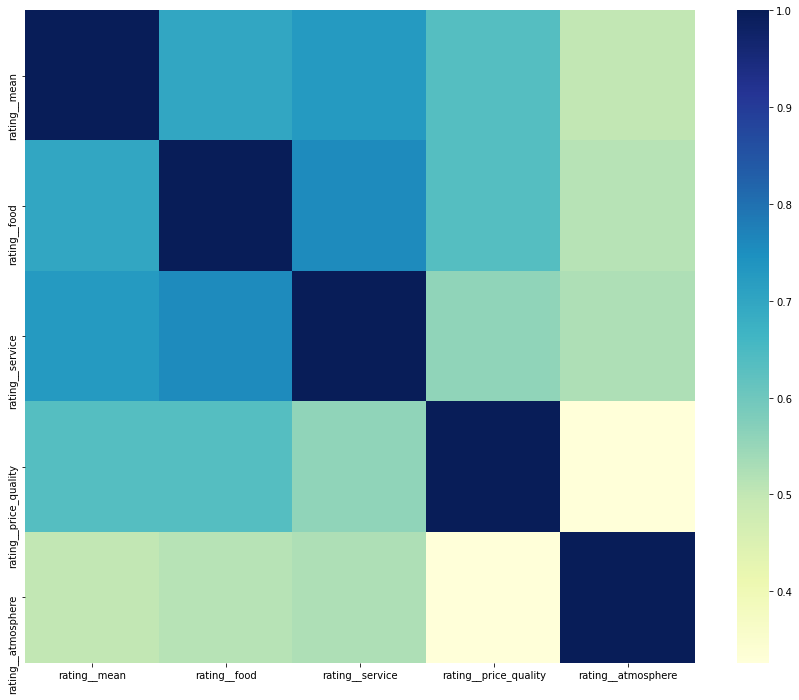

In [222]:
# show heatmap by correlation matrix values

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap="YlGnBu")
plt.show()

### As we can see, the quality of service rating has the greatest impact on the final rating that the visitor puts. Food rating has a slightly lesser impact. Next one is the price-quality rating. And least of all the atmosphere rating.

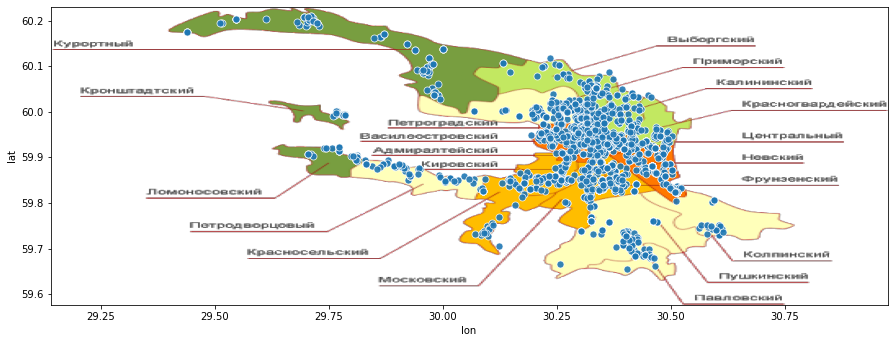

In [306]:
fig, ax = plt.subplots(figsize=(15, 15))
img = plt.imread("common/map.png")
ax.imshow(img, extent=[29.140176, 30.975743, 59.576825, 60.229601])
sns.scatterplot(coords['lon'], coords['lat'], ax=ax, s=50, alpha=0.9)
plt.show()

In [249]:
coords = df.filter(F.col('coords').isNotNull()).select('coords.*').collect()
coords = pd.DataFrame({
                'lon': [lon.coords__lon for lon in coords],
                'lat': [lat.coords__lat for lat in coords]})

In [256]:
coords.describe()

,lon,lat
count,2791.000000,2791.000000
mean,30.306037,59.926537
std,0.156274,0.084553
min,29.440176,59.654273
25%,30.290292,59.880683
50%,30.337595,59.934635
75%,30.369655,59.963058
max,30.615366,60.209980


In [246]:
60.20998 - 59.6542732

0.5557068000000029